In [67]:
%matplotlib inline

import scipy.io as sio
import scipy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import pickle
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

In [68]:
img_data = pickle.load(open('img_data.p', 'rb'))

In [106]:
# Load image
def extract_top_body(img_filename, start_x, end_x, start_y, end_y):
    img = cv2.imread(img_filename)
    extracted_torso = img[start_y:end_y, start_x:end_x]
    return extracted_torso

def generate_bounding_box(r_hip, l_hip, head_top, x_scale=1, y_scale=1):
    # Calculate x_len and y_len between right and left hip
    max_hip_y = max(r_hip[1], l_hip[1])
    mean_hip_x = (r_hip[0] + l_hip[0])/2.0
    diff_hip_x = abs(r_hip[0] - l_hip[0])
    buffer = 0.1 * diff_hip_x
    x_start = mean_hip_x - 0.5 * diff_hip_x * x_scale
    x_end = mean_hip_x + 0.5 * diff_hip_x * x_scale
    
    y_diff = abs(max_hip_y-head_top[1])
    y_start = head_top[1]
    y_end = max_hip_y
    if y_end < y_start:
        y_end = max_hip_y # min_hip_y ?
        y_start = head_top[1]
        
    y_mean = (y_start+y_end)/2.0
    y_start = y_mean - 0.5*y_diff*y_scale
    y_end = y_mean + 0.5*y_diff*y_scale
    
    # x_start, x_end, y_start, y_end
    return (x_start, x_end, y_start, y_end)
     

def generate_windows(x_dim, x_increment, y_dim, y_increment, x_start, y_start, x_lim, y_lim):
    x_lst = []
    curr_x_start = x_start
    curr_x_end = x_start + x_dim
    while curr_x_end <= x_lim:
        x_lst.append((curr_x_start, curr_x_end))
        curr_x_start += x_increment
        curr_x_end += x_increment
        
    y_lst = []
    curr_y_start = y_start
    curr_y_end = y_start + y_dim
    while curr_y_end <= y_lim:
        y_lst.append((curr_y_start, curr_y_end))
        curr_y_start += y_increment
        curr_y_end += y_increment
        
    return (x_lst, y_lst)

def get_all_windows(x_start, y_start, x_lim, y_lim):
    x_lst = []
    y_lst = []
    #x_vals = [(16, 8), (32, 16), (48, 16), (64, 32), (128, 64)]
    x_width = (x_lim-x_start)
    x_window_size = x_width/3.0
    x_step = x_window_size/5.0
    x_vals = [(x_window_size, x_step)]

    #y_vals = [(16, 8), (32, 16), (48, 16), (64, 32), (128, 64)]
    #y_vals = [(128, 32)]
    y_width = (y_lim - y_start)
    y_window_size = y_width/3.0
    y_step = y_window_size/5.0
    y_vals = [(y_window_size, y_step)]
    
    for x_val in x_vals:
        for y_val in y_vals:
            curr_x_lst, curr_y_lst = generate_windows(x_val[0], x_val[1], y_val[0], y_val[1], 
                                                      x_start, y_start, x_lim, y_lim)
            x_lst += curr_x_lst
            y_lst += curr_y_lst
            
    return (x_lst, y_lst)
            
            

def get_hog_features(img):
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    feature_vec = []
    for channel in range(0,3):
        #print(img[:,:,channel])
        features = hog(img[:,:,channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=False, feature_vector=True)
        #print('Feature length: ', len(features))
        feature_vec = feature_vec + list(features)
        
    return feature_vec

def run_classifiers(classifier_map, img):
    max_score = -1
    max_score_cluster_key = -1
    feature_vec = get_hog_features(img)
    feature_vec = np.expand_dims(np.array(feature_vec), axis=0)
    for cluster_key in classifier_map.keys():
        svc  = classifier_map[cluster_key]      
        #feature_vec = features_vec.reshape(1,-1)
        #print('Feature vector shape: ', feature_vec.shape)
        #predict_score = svc.predict(features_vec)
        curr_score  = svc.decision_function(feature_vec)
        if curr_score > max_score:
            max_score = curr_score
            max_score_cluster_key = cluster_key
            
    #print('Max cluster score: ', max_score)
            
    return (max_score_cluster_key, max_score)

def print_cluster_img(cluster_key):
    img = cv2.imread('mp2/cropped_imgs/'+str(cluster_key)+'.jpeg')
    plt.imshow(img[...,::-1])
    plt.show()
    

def test_model(img_filename, joint_dict):
    x_start, x_end, y_start, y_end = \
        generate_bounding_box(joint_dict['r_hip'], joint_dict['l_hip'], joint_dict['head_top'], 3, 3)
    print('Image: ', img_filename)
    img = cv2.imread('mp2/images/'+img_filename)
    boxxed_img = img.copy()
    cv2.rectangle(boxxed_img, (int(x_start), int(y_start)), (int(x_end), int(y_end)), (0,255,0),3)
    plt.imshow(boxxed_img[...,::-1])
    plt.show()
    classifier_map = pickle.load(open('saved_model_map.p', 'rb'))
    
    predicted_pose_cluster = 0
    max_score = 0
    max_score_window = ()
    
    x_lst, y_lst = get_all_windows(x_start, y_start, x_end, y_end)
    for x_range in x_lst:
        for y_range in y_lst:
            curr_x_start, curr_x_end = x_range
            curr_y_start, curr_y_end = y_range
            roi_img = img[int(curr_y_start):int(curr_y_end), int(curr_x_start):int(curr_x_end)]
            roi_img = cv2.resize(roi_img, (96,96))
            #print(img)
            #print(x_start, x_end, y_start, y_end)
            #print(roi_img)
            curr_predicted_pose_cluster, curr_max_score = run_classifiers(classifier_map, roi_img)
            
            if curr_max_score > max_score:
                max_score = curr_max_score
                predicted_pose_cluster = curr_predicted_pose_cluster
                max_score_window = (curr_x_start, curr_x_end, curr_y_start, curr_y_end)
                
    print_cluster_img(predicted_pose_cluster)
    return (predicted_pose_cluster, max_score_window)

# orig_x = co-ordinates of orig_x in original dimensions
def remap_pts(curr_x, curr_y, height, width, orig_x, orig_y):
    return (orig_x+((curr_x/96)*width), orig_y+((curr_y/96)*height))

def calculate_distance_with_cluster_pts(new_joint_lst, cluster_key, 
                                        max_score_window):
    # Get cluster pts for 96x96 window
    predicted_joint_map = new_joint_lst[cluster_key]
    # Get bounding box for test image 
    #x_start, x_end, y_start, y_end = \
    #    generate_bounding_box(test_img_joint_dict['r_hip'], 
    #                          test_img_joint_dict['l_hip'], test_img_joint_dict['head_top'])
    
    x_start, x_end, y_start, y_end = max_score_window
    
    width = (x_end-x_start)
    height = (y_end-y_start)
    # remap_pts()
    predicted_joints = {}
    for joint in ['r_shoulder', 'r_elbow', 'r_wrist']:
        predicted_x, predicted_y = predicted_joint_map[joint]
        remapped_x, remapped_y = remap_pts(predicted_x, predicted_y, height, width, x_start, y_start)
        predicted_joints[joint] = [remapped_x, remapped_y]
    # Return predicted remapped joints
    return predicted_joints
    
def display_test_img_with_predicted_joints(img_name, predicted_joints_dict):
    test_img = cv2.imread('mpii/images/'+img_name)
    print('Predicted joint dict: ', predicted_joints_dict)
    for key, val in predicted_joints_dict.items():
        print("key: ", key, 'x: ', val[0], 'y: ', val[1])
        test_img = cv2.circle(test_img, (int(val[0]), int(val[1])), 2, (0,0,255), 5)
    plt.figure(figsize=(20, 40))
    plt.imshow(test_img[...,::-1])
    plt.show()
    
        
# Create slide window code, sliding window for 3 scales
# Move sliding window across image
# resize sliding window to 96x96
# Run all classifier across image
# Find the classifier that is best match 
# Predict location of joints in the image

Image:  015601864.jpg


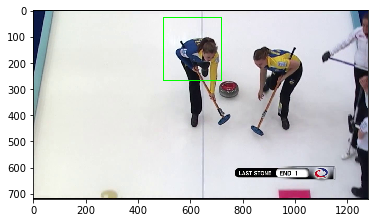

/Users/saurabh/anaconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


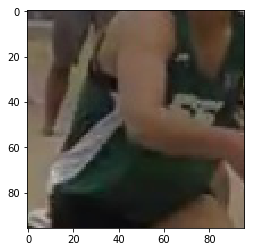

Max score window:  (499.0, 573.0, 172.03633999999997, 251.85464)
Predicted joint dict:  {'r_elbow': [536.0, 211.94548999999998], 'r_wrist': [564.7512270251399, 218.92314762721165], 'r_shoulder': [538.1563420268855, 175.50661128011683]}
key:  r_elbow x:  536.0 y:  211.94548999999998
key:  r_wrist x:  564.7512270251399 y:  218.92314762721165
key:  r_shoulder x:  538.1563420268855 y:  175.50661128011683


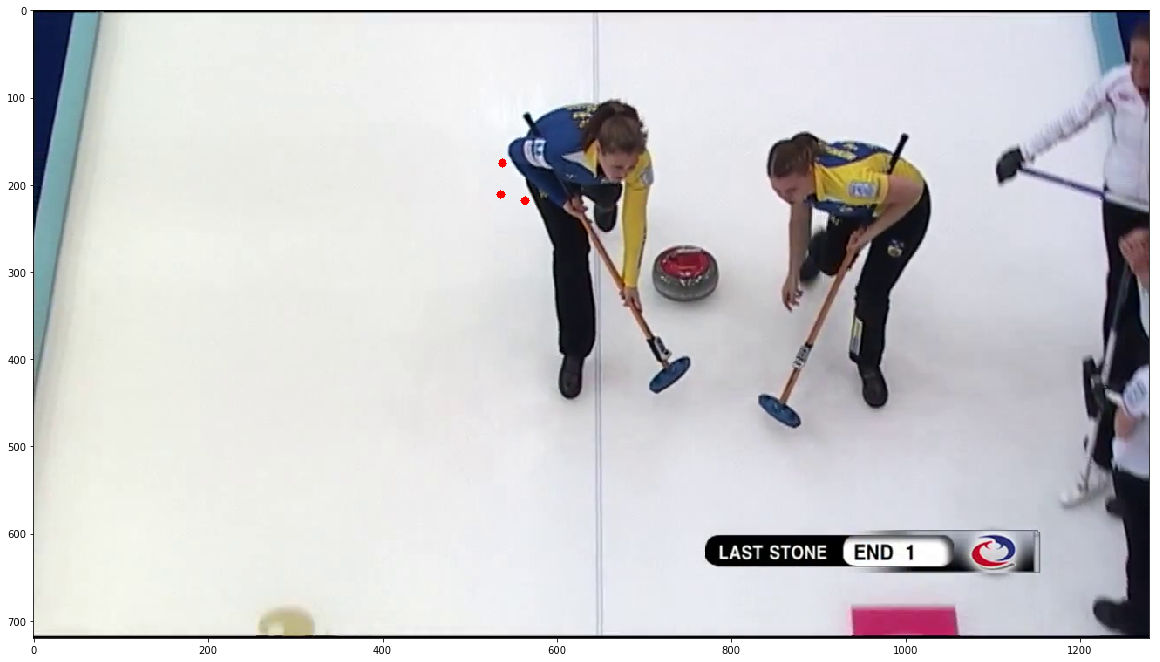

In [107]:
img_lst = img_data['img_lst']
orig_joint_lst = img_data['orig_joint_lst']
test_img_index = 0

new_joint_lst = pickle.load(open('new_joint_lst.p', 'rb'))

cluster_key, max_score_window = test_model(img_lst[test_img_index], orig_joint_lst[0])

print('Max score window: ', max_score_window)

predicted_joints_dict = calculate_distance_with_cluster_pts(new_joint_lst, cluster_key, 
                                        max_score_window)

display_test_img_with_predicted_joints(img_lst[test_img_index], predicted_joints_dict)

In [108]:
#x_dim_lst, y_dim_lst = generate_windows(x_dim, x_increment, y_dim, y_increment, x_start, y_start, x_lim, y_lim)
x_dim_lst, y_dim_lst = generate_windows(32, 16, 32, 16, 0, 0, 48, 48)
print('x_dim_lst: ', x_dim_lst)
print('y_dim_lst: ', y_dim_lst)

x_dim_lst:  [(0, 32), (16, 48)]
y_dim_lst:  [(0, 32), (16, 48)]
